<a href="https://colab.research.google.com/github/pedroheyerdahl/cbers04a/blob/main/cbers_04a_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uq fastai
!pip install rasterio
!pip install -Uq geopandas

In [2]:
import numpy as np
from PIL import Image
import rasterio as rio
from pathlib import Path
from fastai.basics import *
from fastai.vision.all import *
from fastai.vision.core import *
from fastai.vision.data import *
from fastai.data.all import *
import os
from itertools import product
from rasterio import windows
from rasterio.plot import show
import torch
import matplotlib.pyplot as plt
from typing import Tuple
import geopandas as gpd


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Generate numpy stack from tif images (unnecessary if using option 3)

In [73]:
# directory = '/content/drive/MyDrive/CBERS04A/tiles/tif/images/'
    
# for file in os.listdir(directory):
#      filename = os.fsdecode(file)
#      if filename.endswith(".tif"):
#           img = rio.open(os.path.join(directory,file)) 
#           outpath = (os.path.join(directory, 'npy/', os.path.splitext(filename)[0])+'.npy')
#           l = []
#           l.append(img.read(1))
#           l.append(img.read(2))
#           l.append(img.read(3))
#           np_array = np.stack(l)
#           np_array = np_array.astype(int)
#           with open(outpath, 'wb') as f:
#               np.save(f,np_array)

Same, but 1d label masks

In [135]:
# directory = '/content/drive/MyDrive/CBERS04A/tiles/tif/labels/'
    
# for file in os.listdir(directory):
#      filename = os.fsdecode(file)
#      if filename.endswith(".tif"):
#           img = rio.open(os.path.join(directory,file)) 
#           outpath = (os.path.join(directory, 'npy/', os.path.splitext(filename)[0])+'.npy')
#           with open(outpath, 'wb') as f:
#             np_array = img.read(1)
#             np_array = np_array.astype(int)
#             np.save(f,np_array)

Tar everything together

In [ ]:
# import tarfile


# def make_tarfile(output_filename, source_dir):
#     with tarfile.open(output_filename, "w:gz") as tar:
#         tar.add(source_dir, arcname=os.path.basename(source_dir))
        
# make_tarfile('cbers_dataset_sample.tgz','/content/drive/MyDrive/CBERS04A/tiles/')

## Option 1 
from https://towardsdatascience.com/how-to-create-a-datablock-for-multispectral-satellite-image-segmentation-with-the-fastai-v2-bc5e82f4eb5: 
(couldn't get it to work)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checking number of files - images:1443      masks:1443
Checking shapes - image: (3, 256, 256) mask: (256, 256)


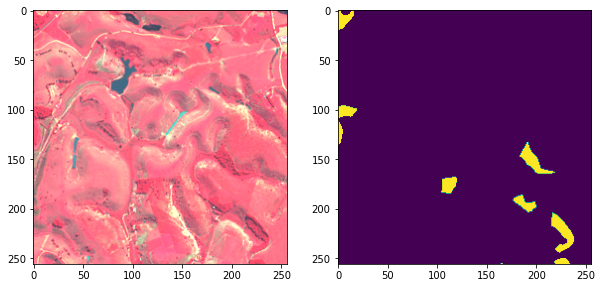

In [165]:
# # Checking files
# npy_path = Path('/content/drive/MyDrive/CBERS04A/tiles/npy')
# npy_imgs_path = npy_path/'images'
# npy_lbls_path = npy_path/'labels'

# print(f'Checking number of files - images:{len([f for f in imgs_path.iterdir()])}\
#       masks:{len([f for f in lbls_path.iterdir()])}')


# # Checking file shapes 
# idx = 1025
# img_path = sorted([f for f in imgs_path.iterdir()])[idx]
# msk_path = sorted([f for f in lbls_path.iterdir()])[idx]
# # print(img_path)
# # print(msk_path)
# img = np.load(str(img_path))
# msk = np.load(str(msk_path))

# print(f'Checking shapes - image: {img.shape} mask: {msk.shape}')

# # Plotting a sample
# _, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(img.transpose((1, 2, 0))[..., [0, 1, 2]])
# ax[1].imshow(msk)

## Option 2:
From fastai2 forum. https://forums.fast.ai/t/using-geotiff-images/71704/10 
Havent tried it. Looks oversimplified

In [ ]:
# f = rasterio.open("path/to.tif")
# red = f.read(1)
# green = f.read(2)
# blue = f.read(3)
# x = TensorImage([red, green, blue])

## Option 3:
From  https://gist.github.com/jaeeolma/88ddd03be2d2d2156cd293d73113051a

There are options using np arrays, but couldn't get it to work. Since it offers a path going straight from TIF to data loader, attempts bellow use only this approach

In [4]:
def open_npy(fn, chans=None):
    im = torch.from_numpy(np.load(str(fn)))
    if chans is not None: im = im[chans]
    return im

def open_geotiff(fn, chans=None):
    with rio.open(str(fn)) as f:
        data = f.read()
        data = data.astype(np.float32)
    im = torch.from_numpy(data)
    if chans is not None: im = im[chans]
    return im

class MultiChannelTensorImage(TensorImage):
    _show_args = ArrayImageBase._show_args
    def show(self, channels=[1], ctx=None, vmin=None, vmax=None, **kwargs):
        "These need refactoring maybe"
        if channels == 'spectra':
            return show_mean_spectra(self, ctx=ctx,  **kwargs)
        if len(channels) == 3: 
            return show_composite(self, channels=channels, ctx=ctx, vmin=vmin, vmax=vmax,
                                  **{**self._show_args, **kwargs})
        if len(channels) == 2:
            return show_normalized_spectral_index(self, channels=channels, ctx=ctx,
                                                  **{**self._show_args, **kwargs})
        elif len(channels) == 1: 
            return show_single_channel(self, channel=channels[0], ctx=ctx, 
                                       **{**self._show_args, **kwargs})

    @classmethod
    def create(cls, fn:(Path,str,ndarray), chans=None,  **kwargs) ->None:
        if isinstance(fn, Tensor): fn = fn.numpy()
        if isinstance(fn, ndarray): 
            im = torch.from_numpy(fn)
            if chans is not None: im = im[chans]
            return cls(im)
        if isinstance(fn, Path) or isinstance(fn, str):
            if str(fn).endswith('npy'): return cls(open_npy(fn=fn, chans=chans))
            elif str(fn).endswith('.tif'): return cls(open_geotiff(fn=fn, chans=chans))
        
    def __repr__(self): return f'{self.__class__.__name__} size={"x".join([str(d) for d in self.shape])}'
    
MultiChannelTensorImage.create = Transform(MultiChannelTensorImage.create) 
        
def show_composite(img, channels, ax=None, figsize=(3,3), title=None, scale=True,
                   ctx=None, vmin=None, vmax=None, scale_axis=(0,1), **kwargs)->plt.Axes:
    "Show three channel composite so that channels correspond to R, G and B"
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)    
    r, g, b = channels
    tempim = img.data.cpu().numpy()
    im = np.zeros((tempim.shape[1], tempim.shape[2], 3))
    im[...,0] = tempim[r]
    im[...,1] = tempim[g]
    im[...,2] = tempim[b]

    if scale: im = norm(im, vmin, vmax, scale_axis)
    ax.imshow(im, **kwargs)
    ax.axis('off')
    if title is not None: ax.set_title(title)
    return ax

def show_single_channel(img, channel, ax=None, figsize=(3,3), ctx=None, 
                        title=None, **kwargs) -> plt.Axes:
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)    
    tempim = img.data.cpu().numpy()
    ax.imshow(norm(tempim[channel], vmin=tempim[channel].min(), vmax=tempim[channel].max()), **kwargs)
    ax.axis('off')
    if title is not None: ax.set_title(title)
    return ax

def show_normalized_spectral_index(img, channels, ax=None, figsize=(3,3), ctx=None,
                                   title=None, **kwargs) -> plt.Axes:
    "Show normalized spectral index such as NDVI"
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    b_0, b_1 = channels
    tempim = img.data.cpu().numpy()
    im = (tempim[b_0] - tempim[b_1])/(tempim[b_0] + tempim[b_1])
    ax.imshow(im, vmin=-1, vmax=1, **kwargs)
    ax.axis('off')
    if title is not None: ax.set_title(title)
    return ax

def show_mean_spectra(img, ax=None, figsize=(3,3), ctx=None, title=None, **kwargs) -> plt.Axes:
    "Show average spectra graph"
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    tempim = img.data.cpu().numpy()
    means = np.nanmean(tempim, axis=(-2, -1))
    ax.plot(means, **kwargs)
    ax.grid(True)
    if title is not None: ax.set_title(title)
    return ax
        
def norm(vals, vmin=None, vmax=None, axis=(0,1)):
    """
    For visualization purposes scale image with `(vals-vmin)/(vmax-vmin), 
    with vmin and vmax either specified or within 0.01 and 0.99 quantiles of all values
    """
    vmin = ifnone(vmin, np.quantile(vals, 0.01, axis=axis))
    vmax = ifnone(vmax, np.quantile(vals, 0.99, axis=axis))
    ret_im = (vals - vmin)/(vmax-vmin)
    ret_im[ret_im < 0] = 0
    ret_im[ret_im > 1] = 1
    return ret_im

In [5]:
def MultiChannelImageBlock(cls=MultiChannelTensorImage, chans=None): 
    "Default behaviour: use all channels"
    return TransformBlock(partial(cls.create, chans=chans))

In [7]:
tif = DataBlock(blocks=(MultiChannelImageBlock()), get_items=partial(get_files, extensions='.tif', recurse=False), splitter=None)

In [8]:
tif_dls = tif.dataloaders(source='/content/drive/MyDrive/CBERS04A/tiles/tif/images', bs=1)
tif_dls.items

[Path('/content/drive/MyDrive/CBERS04A/tiles/tif/images/tile_3328-6912.tif'),
 Path('/content/drive/MyDrive/CBERS04A/tiles/tif/images/tile_4096-4608.tif'),
 Path('/content/drive/MyDrive/CBERS04A/tiles/tif/images/tile_2560-2816.tif'),
 Path('/content/drive/MyDrive/CBERS04A/tiles/tif/images/tile_8192-4096.tif'),
 Path('/content/drive/MyDrive/CBERS04A/tiles/tif/images/tile_4608-0.tif'),
 Path('/content/drive/MyDrive/CBERS04A/tiles/tif/images/tile_4864-512.tif'),
 Path('/content/drive/MyDrive/CBERS04A/tiles/tif/images/tile_6656-7680.tif'),
 Path('/content/drive/MyDrive/CBERS04A/tiles/tif/images/tile_2560-4352.tif'),
 Path('/content/drive/MyDrive/CBERS04A/tiles/tif/images/tile_2560-7168.tif'),
 Path('/content/drive/MyDrive/CBERS04A/tiles/tif/images/tile_3328-4608.tif'),
 Path('/content/drive/MyDrive/CBERS04A/tiles/tif/images/tile_9728-8960.tif'),
 Path('/content/drive/MyDrive/CBERS04A/tiles/tif/images/tile_4864-5376.tif'),
 Path('/content/drive/MyDrive/CBERS04A/tiles/tif/images/tile_0-4864.

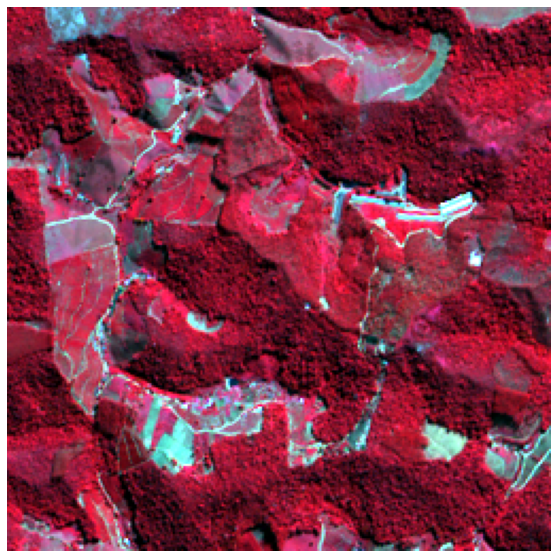

In [9]:
ctxs = tif_dls.show_batch(channels=(0,1,2), figsize=(10,10), scale=True)

In [6]:
#export
def _using_attr(f, attr, x):
    return f(getattr(x,attr))

In [7]:
#export
def using_attr(f, attr):
    "Change function `f` to operate on `attr`"
    return partial(_using_attr, f, attr)

In [8]:
class MultiChannelImageDataLoaders(DataLoaders):
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_folder(cls, path, chans=None, extensions=['.tif'], 
                    train='train', valid='valid', valid_pct=None, seed=None, 
                    vocab=None, item_tfms=None, batch_tfms=None, **kwargs):
        """Create from imagenet style dataset in `path` with `train`, `valid`, `test` subfolders (or provide `valid_pct`).
        Optionally list the channels to use."""
        splitter = GrandparentSplitter(train_name=train, valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct, seed=seed)
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), CategoryBlock(vocab=vocab)),
                           get_items=partial(get_files, extensions=extensions),
                           splitter=splitter,
                           get_y=parent_label,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, path, path=path, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_path_func(cls, path, fnames, label_func,chans=None, extensions=['.tif'], 
                       valid_pct=0.2, seed=None, item_tfms=None, batch_tfms=None, **kwargs):
        """Create from list of `fnames` in `path`s with `label_func`.   
        Optionally list the channels to use."""

        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), CategoryBlock(vocab=vocab)),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, path, path=path, **kwargs)
    
    @classmethod
    def from_name_func(cls, path, fnames, label_func, 
                       chans=None, extensions=['.tif'], **kwargs):
        """Create from name attrs in list of `fnames` in `path`s with `label_func`.
        Optionally list the channels to use."""
        f = using_attr(label_func, 'name')
        return cls.from_path_func(path, fnames, f, chans=chans, **kwargs)

    @classmethod
    def from_path_re(cls, path, fnames, pat, chans=None, extensions=['.tif'], **kwargs):
        """Create from list of `fnames` in `path`s with re expression `pat`.
           Optionally list the channels to use."""
        return cls.from_path_func(path, fnames, RegexLabeller(pat), chans=chans, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_name_re(cls, path, fnames, pat, chans=None, extensions=['.tif'],**kwargs):
        """Create from name attrs in list of `fnames` in `path`s with re expression `pat`.
           Optionally list the channels to use"""
        return cls.from_name_func(path, fnames, RegexLabeller(pat), chans=chans, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_df(cls, df, path='.', chans=None, valid_pct=0.2, seed=None, 
                fn_col=0, folder=None, suff='', label_col=1, label_delim=None,
                y_block=None, valid_col=None, item_tfms=None, batch_tfms=None, **kwargs):
        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        if y_block is None:
            is_multi = (is_listy(label_col) and len(label_col) > 1) or label_delim is not None
            y_block = MultiCategoryBlock if is_multi else CategoryBlock
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), y_block),
                           get_x=ColReader(fn_col, pref=pref, suff=suff),
                           get_y=ColReader(label_col, label_delim=label_delim),
                           splitter=splitter,
                           item_tfms=item_tfms, 
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, df, path=path, **kwargs)

    @classmethod
    def from_shapefile(cls, path, chans=None, shp_fname='labels.shp', **kwargs):
        """Create from shapefile `shp_fname` in `path` readable with geopandas.
        Optionally list the channels to use."""
        df = gpd.read_file(str(Path(path)/shp_fname))
        # Shapefiles don't support boolean columns
        if 'valid_col' in kwargs.keys(): df[kwargs['valid_col']] = df[kwargs['valid_col']].astype(bool)
        return cls.from_df(df, path=path, chans=chans, **kwargs)
    
    @classmethod
    def from_csv(cls, path,  chans=None, csv_fname='labels.csv', 
                 header='infer', delimiter=None, **kwargs):
        df = pd.read_csv(Path(path)/csv_fname, header=header, delimiter=delimiter)
        return cls.from_df(df, path=path, chans=chans, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_lists(cls, path, fnames, labels,chans=None, valid_pct=0.2, 
                   seed:int=None, y_block=None, item_tfms=None, batch_tfms=None,
                   **kwargs):
        """Create from list of `fnames` in `path`. Specify dims to be either 2 (for 2d images) or 3 (for volumetric images)
        and optionally list the channels to use."""
        if y_block is None:
            y_block = MultiCategoryBlock if is_listy(labels[0]) and len(labels[0]) > 1 else (
                RegressionBlock if isinstance(labels[0], float) else CategoryBlock)
        dblock = DataBlock(blocks=(MultiChannelImageBlock(dims=dims, chans=chans), y_block),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           item_tfms=item_tfms, 
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, (fnames, labels), path=path, **kwargs)
    
MultiChannelImageDataLoaders.from_csv = delegates(to=MultiChannelImageDataLoaders.from_df)(MultiChannelImageDataLoaders.from_csv)
MultiChannelImageDataLoaders.from_shapefile = delegates(to=MultiChannelImageDataLoaders.from_df)(MultiChannelImageDataLoaders.from_shapefile)
MultiChannelImageDataLoaders.from_name_func = delegates(to=MultiChannelImageDataLoaders.from_path_func)(MultiChannelImageDataLoaders.from_name_func)
MultiChannelImageDataLoaders.from_path_re = delegates(to=MultiChannelImageDataLoaders.from_path_func)(MultiChannelImageDataLoaders.from_path_re)
MultiChannelImageDataLoaders.from_name_re = delegates(to=MultiChannelImageDataLoaders.from_name_func)(MultiChannelImageDataLoaders.from_name_re)

In [9]:
def get_mask_from_tif(fn):
    return open_geotiff(fn, chans=[0])[0] - 1

In [10]:
class TifSegmentationDataLoaders(DataLoaders):
    "Needs a better name"
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_label_funcs(cls, path, fnames, label_func, chans=None, 
                         extensions=['.tif'], valid_pct=0.2, seed=None, 
                         codes=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`."
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), 
                                   MaskBlock(codes=codes)),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        res = cls.from_dblock(dblock, fnames, path=path, **kwargs)
        return res

In [11]:
## Path for data loader to train.
path = Path('/content/drive/MyDrive/CBERS04A/tiles/tif/')
## Codes are the classes required.
codes = np.array(["none", "forest"])


## get_image_files load data from file paths
fnames = get_image_files(path/"images")
## We also need a function to return the label name from the folder.
def label_func(fn): return path/"labels"/f"{fn.stem}{'.tif'}"


## SegmentationDataLoaders is used as the data loader.
segm = TifSegmentationDataLoaders.from_label_funcs(
    path, bs=4, fnames = fnames, label_func = label_func, codes = codes
)


Loader from original notebook. Not working

In [311]:
# segm = TifSegmentationDataLoaders.from_label_funcs(path='/content/drive/MyDrive/CBERS04A/tiles/tif/images/', bs=4, codes=list(range(0,1)),
#                                                    fnames=get_files('/content/drive/MyDrive/CBERS04A/tiles/tif/images/', extensions=['.tif'], recurse=False),
#                                                    label_func = lambda o: get_mask_from_tif(f'/content/drive/MyDrive/CBERS04A/tiles/tif/labels/{o.stem}{o.suffix}'))

In [12]:
segm.one_batch()

(MultiChannelTensorImage size=4x3x256x256,
 TensorMask([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1],
          ...,
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1]],
 
         [[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1]],
 
         [[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0]]], device='cuda:0'))

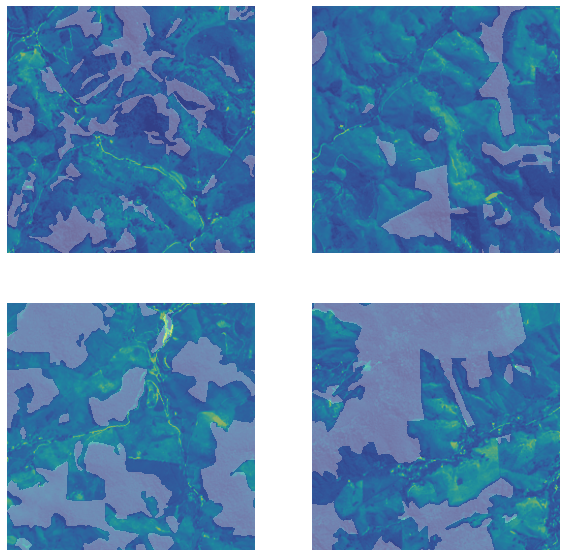

In [13]:
segm.show_batch(vmin=0.0, vmax=1.,figsize=(10,10))

In [14]:
learn = unet_learner(segm, resnet50, metrics=Dice) #see class DiceMulti

In [ ]:
learn.fine_tune(20)

epoch,train_loss,valid_loss,dice,time
0,28.232075,0.597344,0.320376,07:48


epoch,train_loss,valid_loss,dice,time
0,0.309562,0.280359,0.803289,07:39
1,0.260355,0.249404,0.816824,07:40
2,0.238781,0.231915,0.842981,07:40
3,0.233253,0.220814,0.846785,07:39


In [ ]:
learn.show_results(vmin=0., vmax=1.,figsize=(10,10))

In [ ]:
learn.summary()

In [ ]:
learn.save('/content/drive/MyDrive/Models/resnet50_dice')

# How to connect tensorboard with fastai on colab
https://docs.fast.ai/callback.tensorboard.html
https://colab.research.google.com/github/fastai/fastai/blob/master/nbs/71_callback.tensorboard.ipynb
